# Import Required Libraries

In [1]:
!pip install -q python-terrier
!pip install transformers==4.28.0
!pip install datasets
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.4/104.4 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.5/311.5 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from google.colab import drive
import pandas as pd

import nltk
import re

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from collections import Counter
from wordcloud import WordCloud

# import pyterrier as pt

from sklearn.cluster import KMeans
from sklearn import svm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import LabelEncoder

from gensim.models import Word2Vec

import os
import random

import numpy as np

import joblib

from transformers import AlbertTokenizerFast, TFAlbertModel

import tensorflow as tf
import tensorflow.keras.layers as tfkl
from tensorflow.keras.models import Model,load_model, Sequential
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load Data

In [3]:
# Mount the google drive
drive.mount('/content/drive')
# load the dataset
datasetPath = '/content/drive/MyDrive/NLP/EDOS.csv'
df = pd.read_csv(datasetPath)

Mounted at /content/drive


In [4]:
labels = df['eb+_emot'].unique()
pd.set_option('display.max_colwidth', 150)
df.head(5)

,dialogue_id,turn,uttr,eb+_emot,label_confidence
0,97,1,You moron ! What fool washes diapers by the well !,angry,0.437522
1,97,2,You useless fool !,furious,0.731564
2,99,1,How dare you sleep !,furious,0.605636
3,99,2,Up ! Go and clean the house .,prepared,0.650449
4,100,1,Clean the kitchen .,prepared,0.742187


In [5]:
%cd /content/drive/MyDrive/NLP

/content/drive/MyDrive/NLP


# Preprocess

In [ ]:
def preprocess(text):
    # Convert text to lowercase
    text = text.lower()


    text = re.sub(r"'ll", "", text)

    text = re.sub(r"\'re", "", text)

    # Remove punctuation
    text = re.sub(r"[^\w\s]", "", text)
    
    # Remove one-letter words except for "I"
    text = re.sub(r"\b[a-hj-z]\b", "", text)

    # Remove numbers
    text = re.sub(r"\d+", "", text)
    return text

In [ ]:
df['uttr'] = df['uttr'].apply(lambda x: preprocess(x))
df = df.rename(columns={'eb+_emot': 'label'})
df.head()

In [ ]:
# Add column for previous utterance
df['previous_uttr'] = df.groupby('dialogue_id')['uttr'].shift(1)
df['subsequent_uttr'] = df.groupby('dialogue_id')['uttr'].shift(-1)
df.fillna('', inplace=True)
df.head()

In [ ]:
confident_df = df[df['label_confidence']>0.6]
max_instances = 14000
class_counts = confident_df['label'].value_counts()
# Step 4: Undersampling
undersampled_df = pd.DataFrame()
for label in class_counts.index:
    instances = df[df['label'] == label]
    if len(instances) > max_instances:
        # Randomly select instances equal to the maximum allowed
        undersampled_instances = instances.sample(max_instances, random_state=42)
    else:
        # Keep all instances for classes with fewer instances
        undersampled_instances = instances
    undersampled_df = pd.concat([undersampled_df, undersampled_instances])

print(len(undersampled_df))
labels_count = undersampled_df['label'].value_counts()
plt.bar(labels_count.index, labels_count.values)
plt.xticks(rotation=90)
plt.xlabel('Label')
plt.ylabel('Number of samples')
plt.title('Number of Utterance for Each Label')
plt.show()

# **Priminary Analysis**



## A Sample Dialogue

In [ ]:
print('an example :')
dialogue_id = 1159
filtered_df = df[df['dialogue_id'] == dialogue_id]
print(filtered_df.to_string(index=False, justify='center'))

an example :
 dialogue_id  turn                                  uttr                                      label      label_confidence                             previous_uttr                                                         subsequent_uttr                            
    1159       1                                               could you please hurry up     suggesting      0.693129                                                                        NaN i  doing my best  miss  i have  feeling elena will be here any minute 
    1159       2   i  doing my best  miss  i have  feeling elena will be here any minute        hopeful      0.478700                                                 could you please hurry up                                                                let her 
    1159       3                                                                 let her    encouraging      0.510545     i  doing my best  miss  i have  feeling elena will be here any minute    

## Number of Dialogues, Utterance, and Labels

In [ ]:
print('number of dialogue : {}'.format(df['dialogue_id'].nunique()))
print('number of utterance : {}'.format(len(df)))
print('number of labels: {}'.format(len((labels))))

number of dialogue : 1000000
number of utterance : 2829426
number of labels: 41


In [ ]:
print('labels are:\n{}'.format(", ".join(str(label) for label in labels)))


labels are:
angry, furious, prepared, acknowledging, trusting, confident, hopeful, caring, sentimental, anticipating, wishing, surprised, ashamed, questioning, sad, nostalgic, devastated, terrified, embarrassed, lonely, encouraging, suggesting, content, afraid, impressed, agreeing, apprehensive, proud, annoyed, anxious, grateful, excited, neutral, faithful, guilty, consoling, disgusted, disappointed, jealous, joyful, sympathizing


## Statistics


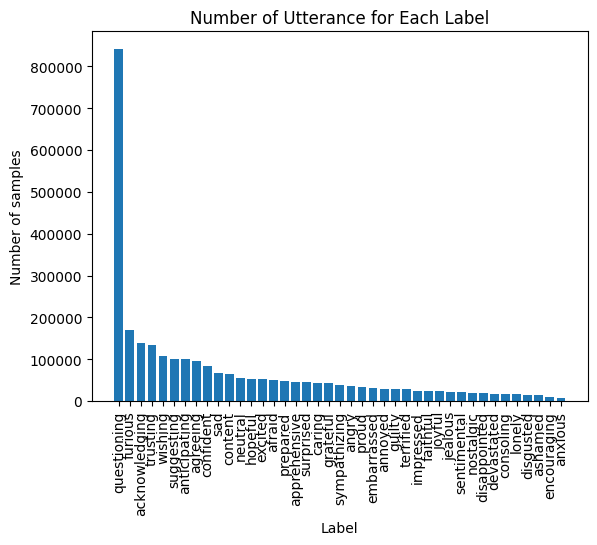

In [ ]:
# Number of Utterance for each label
labels_count = df['label'].value_counts()
plt.bar(labels_count.index, labels_count.values)
plt.xticks(rotation=90)
plt.xlabel('Label')
plt.ylabel('Number of samples')
plt.title('Number of Utterance for Each Label')
plt.show()

In [ ]:
# Number of Utterance in Dialogues 
dialogue_len = df['dialogue_id'].value_counts()
print('In a Dialogue:')
print('maximum number of uttrance: {}'.format(dialogue_len.max()))
print('minimum number of uttrance: {}'.format(dialogue_len.min()))
print('average number of uttrance: {}'.format(dialogue_len.mean()))

In a Dialogue:
maximum number of uttrance: 14
minimum number of uttrance: 2
average number of uttrance: 2.829426


In [ ]:
# Split text into words and calculate the number of words
df['WordCount'] = df['uttr'].apply(lambda x: len(x.split()))

# Calculate average, minimum, and maximum text size
average_size = df['WordCount'].mean()
min_size = df['WordCount'].min()
max_size = df['WordCount'].max()

# Print the results
print("Average uttr size:", average_size)
print("Minimum uttr size:", min_size)
print("Maximum utrr size:", max_size)

Average uttr size: 10.545688772210335
Minimum uttr size: 0
Maximum utrr size: 92


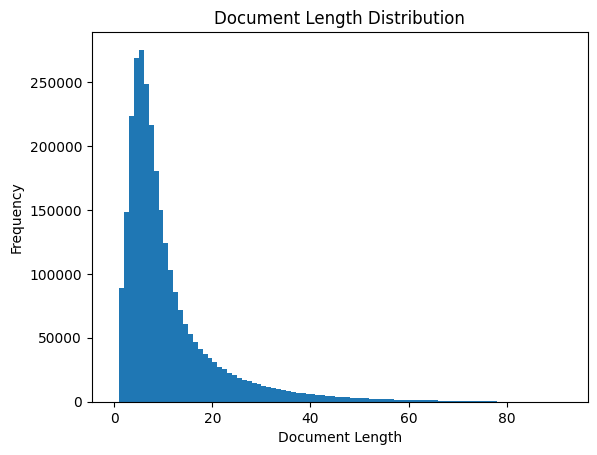

In [ ]:
# Document Length Distribution
plt.hist(df['WordCount'], bins=max_size)
plt.xlabel('Document Length')
plt.ylabel('Frequency')
plt.title('Document Length Distribution')
plt.show()

In [ ]:
# Calculate the 95th percentile
percentile_95 = df['WordCount'].quantile(0.95)
print("95th percentile of WordCount:", percentile_95)

95th percentile of WordCount: 31.0


In [ ]:
# Average Vocabulary Size
df['VocabularySize'] = df['uttr'].apply(lambda x: len(set(x.split())))
average_vocabulary_size = df['VocabularySize'].mean()
print("Average Vocabulary Size: {}".format(average_vocabulary_size))

Average Vocabulary Size: 9.55606684889444


## WordCloud

In [ ]:
nltk.download('stopwords')
def show_wordcloud(label_to_visualize):
  filtered_df = df[df['label'] == label_to_visualize]
  text = ' '.join(filtered_df['uttr'].values)
  # Set the stopwords
  # stopwords = set(STOPWORDS)

  stopwords = nltk.corpus.stopwords.words('english')
  wordcloud = WordCloud(width=800, height=400, background_color='black', stopwords=stopwords).generate(text)
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


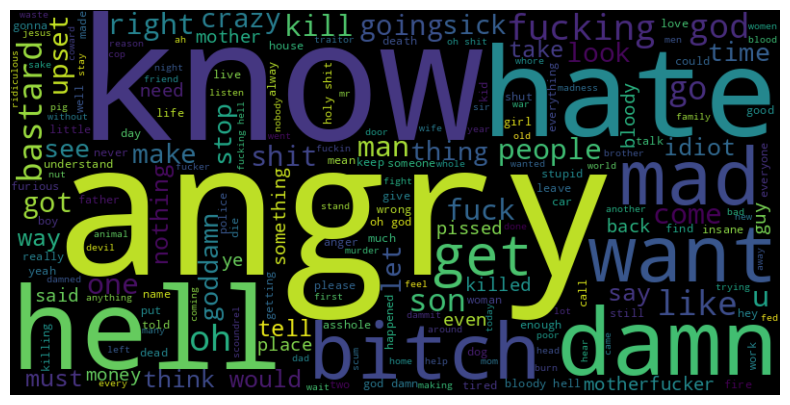

In [ ]:
show_wordcloud('angry')

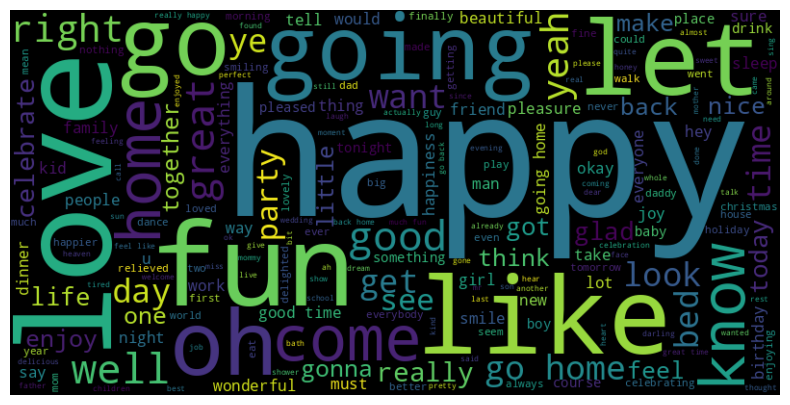

In [ ]:
show_wordcloud('joyful')

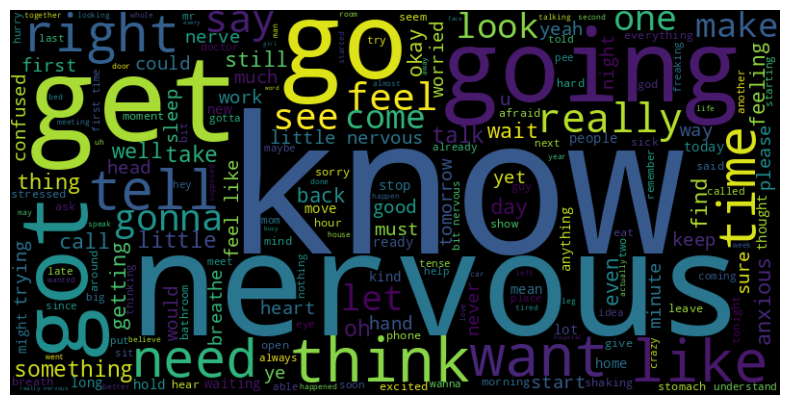

In [ ]:
show_wordcloud('anxious')

## Indexing Documents(Dialouges) for Keyword Search

In [ ]:
# !rm -rf index_dial

In [ ]:
# Making a balanced smaller dataset
selected_df = df.groupby('label').apply(lambda x: x.sample(n=500, random_state=42)).reset_index(drop=True)

In [ ]:
#Initialize the Terrier
if not pt.started():
  pt.init()

terrier-assemblies 5.7 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.7 jar not found, downloading to /root/.pyterrier...
Done


PyTerrier 0.9.2 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7



In [ ]:
#indexing the documents
indexer = pt.DFIndexer("./index_uttr", overwrite=True)
selected_df['docno'] = selected_df.index.astype(str)
index_ref = indexer.index(selected_df["uttr"], selected_df['docno'])

/usr/local/lib/python3.10/dist-packages/pyterrier/index.py:628: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, value in meta_column[1].iteritems():


14:48:15.865 [main] WARN org.terrier.structures.indexing.Indexer - Adding an empty document to the index (53) - further warnings are suppressed
14:48:30.903 [main] WARN org.terrier.structures.indexing.Indexer - Indexed 207 empty documents


In [ ]:
# load the index
index = pt.IndexFactory.of(index_ref)

In [ ]:
# Collection Statistics
print(index.getCollectionStatistics().toString())

Number of documents: 20500
Number of terms: 14399
Number of postings: 118749
Number of fields: 0
Number of tokens: 124410
Field names: []
Positions:   false



In [ ]:
# Looking up a term
index.getLexicon()["walk"].toString()

'term584 Nt=100 TF=104 maxTF=2 @{0 211562 5}'

In [ ]:
# search an index
query = 'I hate you, bitch'
br = pt.BatchRetrieve(index, wmodel="BM25")
results = br.search(query)
docno = results["docno"].iloc[0:5]
selected_df.iloc[(docno)]

,dialogue_id,turn,uttr,label,label_confidence,WordCount,VocabularySize,docno
1791,3748864,2,i said bitch bitch bitch bitch,angry,0.568931,6,3,1791
1678,5403451,2,this hate is not good i just hate him,angry,0.721932,9,8,1678
1514,2134768,2,this bitch is stubborn,angry,0.545585,4,4,1514
1664,2360743,1,motherfucking bitch,angry,0.559951,2,2,1664
1830,8224148,4,treacherous bitch,angry,0.637634,2,2,1830


## Word2Vec

In [ ]:
sentences = list(pd.core.common.flatten(df['uttr']))
tokenized_sentences = [sentence.split() for sentence in sentences]
# remove sentences that are only 1 word long
tokenized_sentences = [sentence for sentence in tokenized_sentences if len(sentence) > 1]

for sentence in tokenized_sentences[:10]:
    print(sentence)

['you', 'moron', 'what', 'fool', 'washes', 'diapers', 'by', 'the', 'well']
['you', 'useless', 'fool']
['how', 'dare', 'you', 'sleep']
['up', 'go', 'and', 'clean', 'the', 'house']
['clean', 'the', 'kitchen']
['i', 'cleaned', 'the', 'kitchen', 'ma', 'am']
['your', 'name', 'means', 'to', 'trust', 'it', 'also', 'means', 'truth', 'and', 'endurance', 'or', 'it', 'could', 'be', 'god']
['you', 'were', 'given', 'great', 'name', 'you', 'better', 'live', 'up', 'to', 'it']
['i', 'go', 'home', 'in', 'the', 'spring', 'once', 'the', 'snow', 'melts']
['listen', 'no', 'matter', 'how', 'tough', 'it', 'gets', 'i', 'wouldn', 'bring', 'shame', 'to', 'you', 'and', 'your', 'dad', 'i', 'promise', 'i', 'won']


In [ ]:
# Check if saved model exists
if os.path.isfile('word2vec_model.bin'):
    model = Word2Vec.load("word2vec_model.bin")
else:
  # Train the Word2Vec model
  model = Word2Vec(tokenized_sentences, vector_size=30, min_count=5, window=10)
  # Save the Word2Vec model
  model.save("word2vec_model.bin")

In [ ]:
print('vocabulary size of our word2vec model is {}'.format(len(model.wv)))

vocabulary size of our word2vec model is 60817


In [ ]:
# print out one of the vectors
term = 'happy'
model.wv[term]

array([ 0.5185962 ,  3.3942895 , -0.08089029,  2.8449283 ,  3.4004362 ,
       -6.5655084 , -6.6350274 ,  4.4951706 ,  3.351493  ,  3.3958063 ,
       -2.1524386 ,  2.5502126 , -0.62973523, -3.1667037 , -2.9216402 ,
        1.3654761 ,  1.080323  ,  4.1385345 ,  0.02783501,  2.2166293 ,
        6.118074  ,  0.3501826 , -1.5857924 ,  0.69939595, -1.7671508 ,
        0.81052697, -0.01353668,  1.0386821 ,  4.0185432 ,  1.2980305 ],
      dtype=float32)

In [ ]:
# Get the closest neighbouring terms(cosine distance)
term ='woman'
print(f"The most similar words to '{term}':")
for similar_word, similarity in model.wv.most_similar(term):
    print(f"- {similar_word}: {similarity}")

The most similar words to 'woman':
- girl: 0.8790802359580994
- person: 0.8175948858261108
- prostitute: 0.7972064018249512
- child: 0.7729090452194214
- lover: 0.7723482847213745
- jealousy: 0.7562456130981445
- nun: 0.735654354095459
- man: 0.7339341640472412
- stranger: 0.7311246991157532
- witch: 0.7297357320785522


In [ ]:
# Find the word that completes the analogy "king - man + woman = ?"
analogy_result = model.wv.most_similar(positive=['king', 'woman'], negative=['man'], topn=1)
# Print the result
print(f"Result of the analogy 'king - man + woman': {analogy_result[0][0]}")

Result of the analogy 'king - man + woman': queen


In [ ]:
# choose a random subset of 500 terms to show
sample = random.sample(list(model.wv.key_to_index), 200)
#  get the word vectors for the sampled terms
word_vectors = model.wv[sample]
# provide the vectors to TSNE to fit a model and transform the data to 3 dimensions
tsne = TSNE(n_components=3, n_iter=2000)
tsne_embedding = tsne.fit_transform(word_vectors)

In [ ]:
# transform the data into 3 columns 
x, y, z = np.transpose(tsne_embedding)

In [ ]:
fig = px.scatter_3d(x=x[:200],y=y[:200],z=z[:200],text=sample[:200])
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

In [ ]:
# Add some specific terms to sample:
colours = ['red','green','blue','orange','yellow','purple','pink','cream','brown','black','white','gray']

word_vectors = model.wv[colours+sample]

tsne = TSNE(n_components=3)
tsne_embedding = tsne.fit_transform(word_vectors)

x, y, z = np.transpose(tsne_embedding)

In [ ]:
r = (-200,200)
fig = px.scatter_3d(x=x, y=y, z=z, range_x=r, range_y=r, range_z=r, text=colours + [None] * 200)
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

## KMean Clustering(tf-idf)

In [ ]:
# Making a balanced smaller dataset
selected_df = df.groupby('label').apply(lambda x: x.sample(n=500, random_state=42)).reset_index(drop=True)

In [ ]:
# Create an instance of TfidfVectorizer with the custom tokenizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(selected_df['uttr'])

In [ ]:
# Deviding data into k cluster
k=10
kmeans = KMeans(n_clusters=k, random_state=42,n_init=10,verbose=0)
kmeans.fit(X)
selected_df['cluster'] = kmeans.labels_

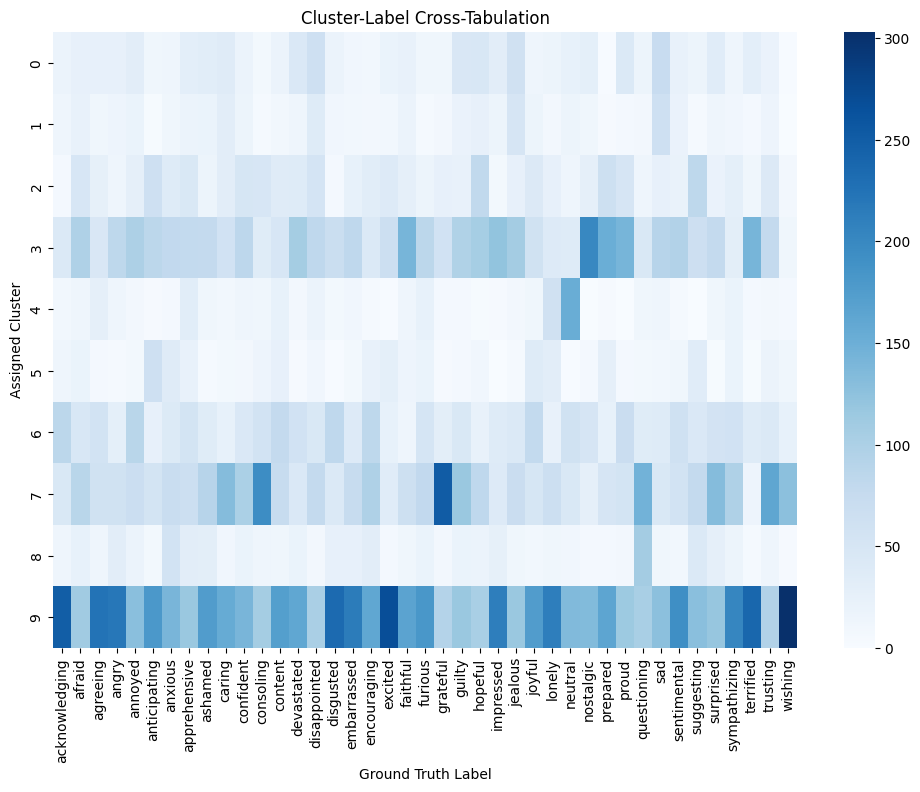

In [ ]:
cross_tab = pd.crosstab(selected_df['cluster'], selected_df['label'])
plt.figure(figsize=(12, 8))
sns.heatmap(cross_tab, cmap='Blues')
plt.title('Cluster-Label Cross-Tabulation')
plt.xlabel('Ground Truth Label')
plt.ylabel('Assigned Cluster')
plt.show()

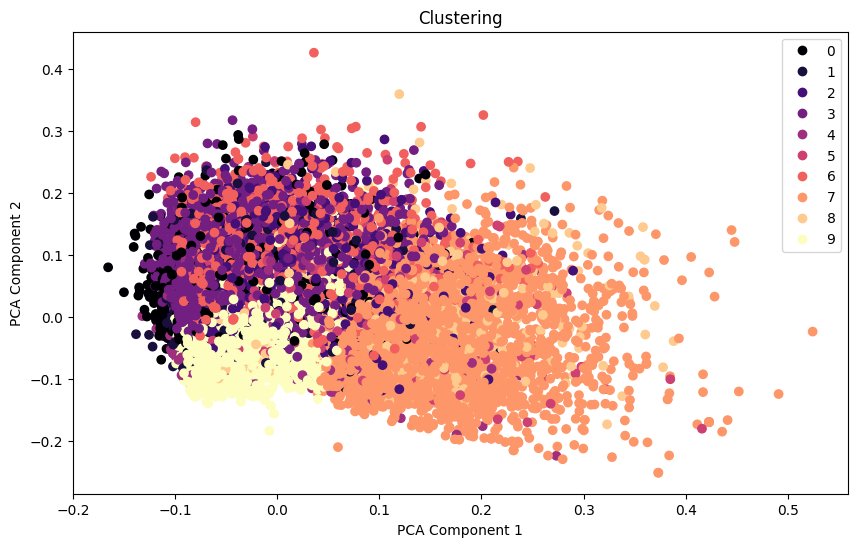

In [ ]:
# perfoming randomized PCA to reduce dimensionality
rpca = PCA(n_components=2, svd_solver='randomized')
X_pca = rpca.fit_transform(X.toarray())

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=selected_df['cluster'], cmap='magma')
plt.legend(handles=scatter.legend_elements()[0], labels=range(10))
plt.title('Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

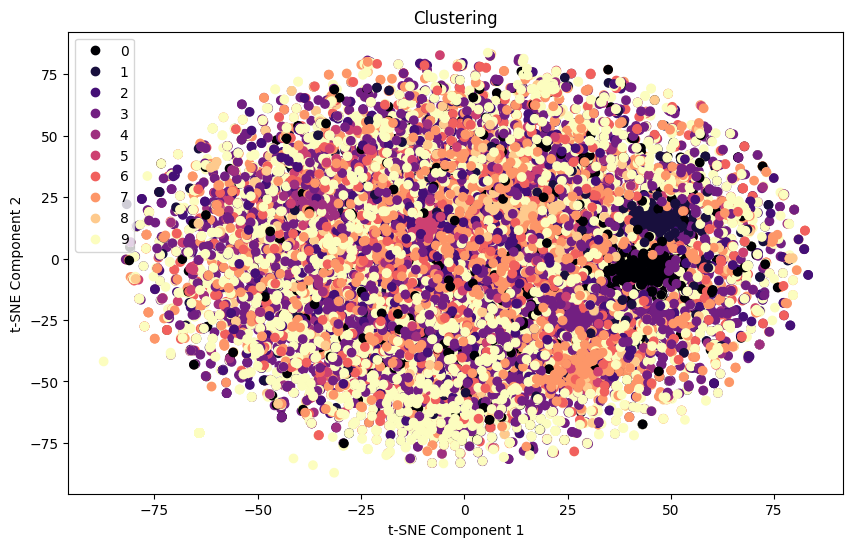

In [ ]:
# Perform t-SNE to reduce dimensionality
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

# Plot the t-SNE scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=selected_df['cluster'], cmap='magma')
plt.legend(handles=scatter.legend_elements()[0], labels=range(10))
plt.title('Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

## KMean Clustering(Word2Vec)

In [ ]:
# Making a balanced smaller dataset
confident_df = df[df['label_confidence']>0.6]
selected_df = confident_df.groupby('label').apply(lambda x: x.sample(n=1000, random_state=42)).reset_index(drop=True)

In [ ]:
# Vectorize sentences with word2Vec
sentence_vectors = []
# Create a list to store the rows that satisfy the condition
selected_rows = []

# Iterate over each sentence and row in the selected_df
for sentence, row in zip(selected_df['uttr'], selected_df.iterrows()):
    vectors = [model.wv[word] for word in sentence.split() if word in model.wv]
    if vectors:
        sentence_vector = sum(vectors) / len(vectors)
        sentence_vectors.append(sentence_vector)
        selected_rows.append(row[1])  # Append the entire row to selected_rows list

# Create a dataframe from selected_rows list
selected_rows_df = pd.DataFrame(selected_rows)

In [ ]:
# Deviding data into 41 cluster
k=41
kmeans = KMeans(n_clusters=k, random_state=42,n_init=10,verbose=0)
kmeans.fit(sentence_vectors)
selected_rows_df['cluster'] = kmeans.labels_

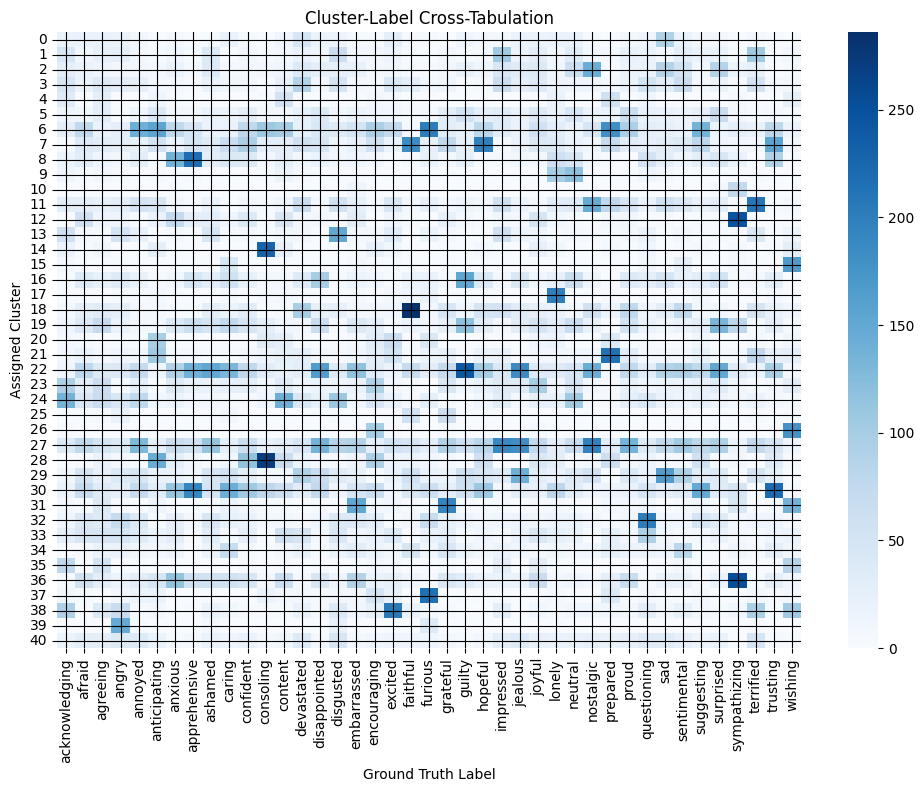

In [ ]:
cross_tab = pd.crosstab(selected_rows_df['cluster'], selected_rows_df['label'])
plt.figure(figsize=(12, 8))
sns.heatmap(cross_tab, cmap='Blues')
plt.title('Cluster-Label Cross-Tabulation')
plt.xlabel('Ground Truth Label')
plt.ylabel('Assigned Cluster')
plt.grid(True, which='both', color='black')
plt.show()

# **Models**

## Naive Bayes

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(undersampled_df['uttr'], undersampled_df['label'], test_size=0.2, random_state=42)

In [ ]:
# Create a CountVectorizer to convert text into a matrix of token counts
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)


In [ ]:
# Transform the test set into the same vectorized format
X_test_counts = vectorizer.transform(X_test)

# Predict the sentiment labels for the test set
y_pred = clf.predict(X_test_counts)

# Generate the classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Classification Report:
               precision    recall  f1-score   support

acknowledging       0.52      0.14      0.22      2720
       afraid       0.54      0.54      0.54      2858
     agreeing       0.69      0.24      0.35      2776
        angry       0.70      0.36      0.47      2737
      annoyed       0.46      0.44      0.45      2937
 anticipating       0.56      0.38      0.45      2880
      anxious       0.77      0.28      0.41      1728
 apprehensive       0.31      0.63      0.42      2745
      ashamed       0.51      0.42      0.46      2749
       caring       0.41      0.44      0.42      2810
    confident       0.41      0.18      0.25      2774
    consoling       0.56      0.57      0.57      2811
      content       0.58      0.50      0.54      2711
   devastated       0.65      0.41      0.50      2779
 disappointed       0.33      0.63      0.43      2791
    disgusted       0.71      0.59      0.65      2775
  embarrassed       0.66      0.55      0

## SVM 
using countvectorizer, and tf-idf vectorizer

In [ ]:
selected_df = undersampled_df.groupby('label').apply(lambda x: x.sample(n=1000, random_state=42)).reset_index(drop=True)

In [ ]:
# Split the data into training and testing sets
X = selected_df['uttr']
y = selected_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Count Vectorizer

In [ ]:
# Text preprocessing using CountVectorizer
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [ ]:
## Model Building

# Check if saved model exists
if os.path.isfile('svm_countvec.pkl'):
    classifier = joblib.load('svm_countvec.pkl')
else:
    # Initialize the SVM classifier
    classifier = svm.SVC(kernel='linear')
    # Train the classifier
    classifier.fit(X_train_vectorized, y_train)
    # Save the SVM model
    joblib.dump(classifier, 'svm_countvec.pkl')

In [ ]:
# Make predictions on the test set
predictions = classifier.predict(X_test_vectorized)

# Generate the classification report
report = classification_report(y_test, predictions)
print("Classification Report:")
print(report)

Classification Report:
               precision    recall  f1-score   support

acknowledging       0.21      0.47      0.30       207
       afraid       0.57      0.45      0.51       221
     agreeing       0.36      0.48      0.41       203
        angry       0.59      0.41      0.49       211
      annoyed       0.24      0.23      0.24       193
 anticipating       0.36      0.56      0.43       194
      anxious       0.55      0.54      0.55       220
 apprehensive       0.34      0.47      0.39       199
      ashamed       0.44      0.25      0.32       204
       caring       0.36      0.50      0.42       189
    confident       0.24      0.26      0.25       188
    consoling       0.47      0.59      0.52       184
      content       0.52      0.55      0.54       211
   devastated       0.38      0.39      0.39       185
 disappointed       0.40      0.34      0.37       218
    disgusted       0.61      0.34      0.44       187
  embarrassed       0.58      0.44      0

In [ ]:
# Example: Predict sentiment for a new input
new_input = ['Don\'t mention it, Mr. Parker. It\'s just too bad we couldn\'t have stopped that ten-gallon grease ball from stealing our ranch.']
new_input_vectorized = vectorizer.transform(new_input)
predicted_sentiment = classifier.predict(new_input_vectorized )
print(f"Predicted sentiment: {predicted_sentiment}")

Predicted sentiment: ['disappointed']


### TF-IDF Vectorizer

In [ ]:
# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()
# Fit and transform the training data
X_train_tfidf = vectorizer.fit_transform(X_train.astype(str))

In [ ]:
## Model Building

# Check if saved model exists
if os.path.isfile('svm_tfidf.pkl'):
    classifier = joblib.load('svm_tfidf.pkl')
else:
    # Initialize the SVM classifier
    classifier = svm.SVC(kernel='linear')
    # Train the classifier
    classifier.fit(X_train_tfidf, y_train)
    # Save the SVM model
    joblib.dump(classifier, 'svm_tfidf.pkl')

In [ ]:
## Test

# Transform the test data
X_test_tfidf = vectorizer.transform(X_test.astype(str))

# Make predictions on the test set
predictions = classifier.predict(X_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.4502439024390244


In [ ]:
# Example: Predict sentiment for a new input
new_input = ['Don\'t mention it, Mr. Parker. It\'s just too bad we couldn\'t have stopped that ten-gallon grease ball from stealing our ranch.']
new_input_tfidf = vectorizer.transform(new_input)
predicted_sentiment = classifier.predict(new_input_tfidf)
print(f"Predicted sentiment: {predicted_sentiment}")

Predicted sentiment: ['disappointed']


## Logistic Regression

In [ ]:
utterances = undersampled_df['uttr'].values
labels = undersampled_df['label'].values

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(utterances, labels, test_size=0.2, random_state=42)

In [ ]:
# Vectorize the utterances using TF-IDF
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [ ]:
# Train a logistic regression model
classifier = LogisticRegression(verbose=1,n_jobs=-1)
classifier.fit(X_train_vectorized, y_train)

# Predict the sentiment labels for the test set
y_pred = classifier.predict(X_test_vectorized)

# Print classification report
print(classification_report(y_test, y_pred))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  3.4min finished


               precision    recall  f1-score   support

acknowledging       0.37      0.40      0.39      2720
       afraid       0.66      0.58      0.62      2858
     agreeing       0.48      0.45      0.47      2776
        angry       0.61      0.53      0.57      2737
      annoyed       0.49      0.46      0.47      2937
 anticipating       0.51      0.53      0.52      2880
      anxious       0.64      0.56      0.60      1728
 apprehensive       0.51      0.57      0.53      2745
      ashamed       0.55      0.46      0.50      2749
       caring       0.49      0.51      0.50      2810
    confident       0.37      0.31      0.34      2774
    consoling       0.63      0.63      0.63      2811
      content       0.57      0.59      0.58      2711
   devastated       0.58      0.57      0.58      2779
 disappointed       0.55      0.54      0.55      2791
    disgusted       0.70      0.69      0.70      2775
  embarrassed       0.74      0.59      0.66      2808
  encoura

## LSTM
using word2Vec Embedding

### Prepare Data

In [ ]:
# Load Word2Vec model
word2vec_model = Word2Vec.load("word2vec_model.bin")
word_vectors = word2vec_model.wv

In [ ]:
# Prepare the input data and labels
X = undersampled_df['uttr'].values
y = undersampled_df['label'].values

In [ ]:
# Encode the labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [ ]:
# Split the data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
# Define the maximum sequence length
max_seq_length = 35

In [ ]:
# Convert each utterance to a sequence of word indices
X_train_seq = []
for utterance in X_train:
    seq = []
    for word in utterance.split():
        if word in word_vectors:
            seq.append(word_vectors.key_to_index[word])
    X_train_seq.append(seq)
X_train_seq = pad_sequences(X_train_seq, maxlen=max_seq_length, padding='post', truncating='post')
print(X_train_seq.shape)

In [ ]:
X_val_seq = []
for utterance in X_val:
    seq = []
    for word in utterance.split():
        if word in word_vectors:
            seq.append(word_vectors.key_to_index[word])
    X_val_seq.append(seq)
X_val_seq = pad_sequences(X_val_seq, maxlen=max_seq_length, padding='post', truncating='post')
print(X_val_seq.shape)

(90385, 35)


In [ ]:
X_test_seq = []
for utterance in X_test:
    seq = []
    for word in utterance.split():
        if word in word_vectors:
            seq.append(word_vectors.key_to_index[word])
    X_test_seq.append(seq)
X_test_seq = pad_sequences(X_test_seq, maxlen=max_seq_length, padding='post', truncating='post')
print(X_test_seq.shape)

(112982, 35)


In [ ]:
# Convert the lists to numpy arrays
X_train_seq = np.array(X_train_seq)
X_val_seq = np.array(X_val_seq)
X_test_seq = np.array(X_test_seq)

In [ ]:
vocab_size = len(word_vectors.key_to_index) + 1  # Add 1 for the padding token
embedding_dim = word_vectors.vector_size

# Convert word indices to word embeddings
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in word_vectors.key_to_index.items():
    embedding_matrix[index] = word_vectors.get_vector(word)

### Train the Model

In [ ]:
# Define the LSTM model
model = Sequential()

# Define the embedding layer
embedding_layer = tfkl.Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False)
model.add(embedding_layer)
model.add(tfkl.LSTM(units=64))
model.add(tfkl.Dense(units=len(labels), activation='softmax'))

# Compile the model with sparse categorical cross-entropy loss and AdamW optimizer
model.compile(loss='sparse_categorical_crossentropy', optimizer=AdamW(), metrics=['accuracy'])

# Define early stopping and model checkpoint callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('lstm_word2Vec.h5', monitor='val_loss', save_best_only=True)

# Train the model with early stopping and model checkpoint callbacks
history = model.fit(X_train_seq, y_train, validation_data=(X_val_seq, y_val), epochs=10, batch_size=32,
                    callbacks=[early_stopping, checkpoint])


Epoch 1/10
11299/11299 [==============================] - 104s 9ms/step - loss: 2.3386 - accuracy: 0.3503 - val_loss: 2.0282 - val_accuracy: 0.4269
Epoch 2/10
11299/11299 [==============================] - 71s 6ms/step - loss: 1.9542 - accuracy: 0.4427 - val_loss: 1.9330 - val_accuracy: 0.4496
Epoch 3/10
11299/11299 [==============================] - 71s 6ms/step - loss: 1.8741 - accuracy: 0.4625 - val_loss: 1.8851 - val_accuracy: 0.4607
Epoch 4/10
11299/11299 [==============================] - 71s 6ms/step - loss: 1.8292 - accuracy: 0.4735 - val_loss: 1.8466 - val_accuracy: 0.4709
Epoch 5/10
11299/11299 [==============================] - 71s 6ms/step - loss: 1.7996 - accuracy: 0.4815 - val_loss: 1.8291 - val_accuracy: 0.4737
Epoch 6/10
11299/11299 [==============================] - 68s 6ms/step - loss: 1.7800 - accuracy: 0.4857 - val_loss: 1.8128 - val_accuracy: 0.4802
Epoch 7/10
11299/11299 [==============================] - 70s 6ms/step - loss: 1.7631 - accuracy: 0.4906 - val_loss: 

### Evaluate Model

In [ ]:
# Load the best model checkpoint
model.load_weights('lstm_word2Vec.h5')

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test_seq, y_test)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

3531/3531 [==============================] - 13s 4ms/step - loss: 1.7718 - accuracy: 0.4888
Test Loss: 1.7718310356140137
Test Accuracy: 0.48883894085884094


In [ ]:
# Get predictions for the test data
y_pred = model.predict(X_test_seq)
y_pred_labels = np.argmax(y_pred, axis=1)

# Print classification report
print(classification_report(y_test, y_pred_labels, target_names=label_encoder.classes_))

3531/3531 [==============================] - 12s 4ms/step
               precision    recall  f1-score   support

acknowledging       0.34      0.32      0.33      2720
       afraid       0.56      0.56      0.56      2858
     agreeing       0.43      0.44      0.44      2776
        angry       0.52      0.43      0.48      2737
      annoyed       0.38      0.28      0.32      2937
 anticipating       0.48      0.49      0.48      2880
      anxious       0.53      0.47      0.49      1728
 apprehensive       0.45      0.53      0.49      2745
      ashamed       0.38      0.40      0.39      2749
       caring       0.42      0.41      0.42      2810
    confident       0.35      0.35      0.35      2774
    consoling       0.59      0.58      0.58      2811
      content       0.53      0.59      0.56      2711
   devastated       0.41      0.45      0.43      2779
 disappointed       0.45      0.36      0.40      2791
    disgusted       0.61      0.53      0.57      2775
  emba

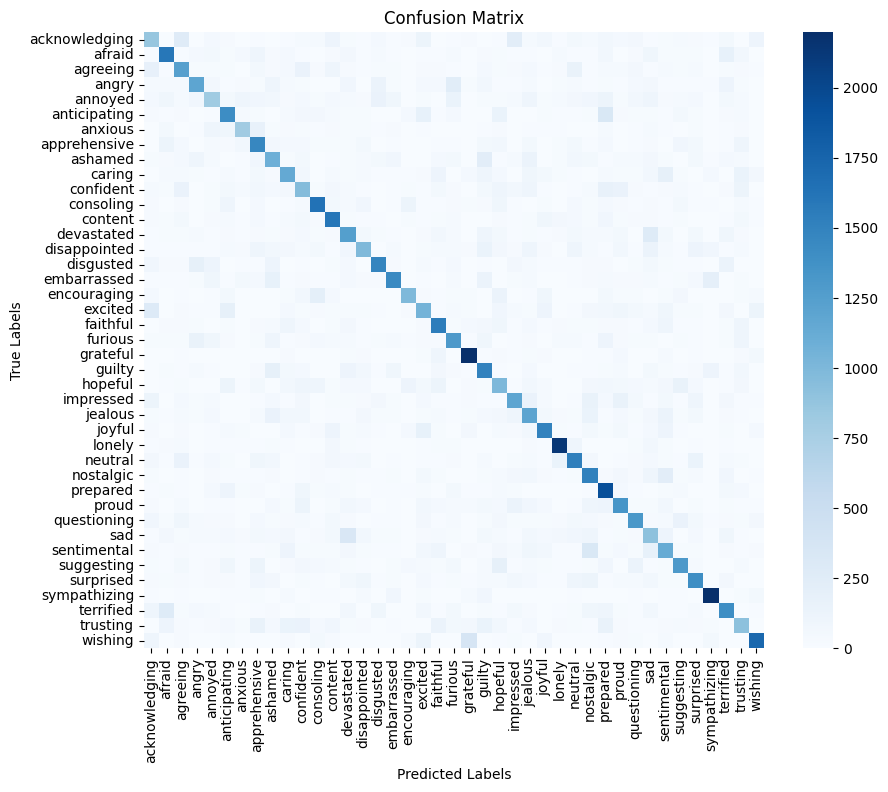

In [ ]:
# Plot confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap='Blues', fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Transformer-Based Model(ALBERT)



### No Info about Previous or Subsequent Uttr

#### Prepare Data

In [ ]:
# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')
# Enable XLA
tf.config.optimizer.set_jit(True)

In [ ]:
# Split data into train, validation, and test sets
train_df, test_df = train_test_split(undersampled_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)
print('number of train samples : {}'.format(len(train_df)))
print('number of test samples : {}'.format(len(test_df)))
print('number of val samples : {}'.format(len(val_df)))

number of train samples : 361540
number of test samples : 112982
number of val samples : 90385


In [ ]:
# Encode labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df['label'])
val_labels = label_encoder.transform(val_df['label'])
test_labels = label_encoder.transform(test_df['label'])

In [ ]:
# Load ALBERT tokenizer (fast version)
tokenizer = AlbertTokenizerFast.from_pretrained('albert-base-v2')

In [ ]:
# Tokenize
max_length = 35  # Maximum sequence length (>95 percentile of utterance langth)
train_tokens = tokenizer.batch_encode_plus(
    train_df['uttr'].tolist(),
    max_length=max_length,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)
test_tokens = tokenizer.batch_encode_plus(
    test_df['uttr'].tolist(),
    max_length=max_length,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)
val_tokens = tokenizer.batch_encode_plus(
    val_df['uttr'].tolist(),
    max_length=max_length,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

In [ ]:
# Convert tokenized input to numpy arrays
train_input_ids = np.array(train_tokens['input_ids'])
train_attention_mask = np.array(train_tokens['attention_mask'])
val_input_ids = np.array(val_tokens['input_ids'])
val_attention_mask = np.array(val_tokens['attention_mask'])
test_input_ids = np.array(test_tokens['input_ids'])
test_attention_mask = np.array(test_tokens['attention_mask'])

#### Train Model

In [ ]:
albert_model = TFAlbertModel.from_pretrained('albert-base-v2')
albert_model.trainable = False

Some layers from the model checkpoint at albert-base-v2 were not used when initializing TFAlbertModel: ['predictions']
- This IS expected if you are initializing TFAlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFAlbertModel were initialized from the model checkpoint at albert-base-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


In [ ]:
input_ids = tfkl.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
attention_mask = tfkl.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')
albert_output = albert_model(input_ids={'input_ids': input_ids, 'attention_mask': attention_mask}).last_hidden_state
pooler_output = albert_output[:, 0, :]  # Extract pooled output

# Add a Bidirectional LSTM layer
lstm_units = 64
lstm_output = tfkl.Bidirectional(tfkl.LSTM(lstm_units))(albert_output)

output = tfkl.Dense(len(label_encoder.classes_), activation='softmax')(lstm_output)
model = Model(inputs=[input_ids, attention_mask], outputs=output)

# Compile the model
learning_rate = 0.5e-3
optimizer = AdamW(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# Train the model
model.fit(
    [train_input_ids, train_attention_mask],
    train_labels,
    validation_data=([val_input_ids, val_attention_mask], val_labels),
    batch_size=32,
    epochs=10,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
11299/11299 [==============================] - 377s 31ms/step - loss: 1.7888 - accuracy: 0.4855 - val_loss: 1.5114 - val_accuracy: 0.5510
Epoch 2/10
11299/11299 [==============================] - 355s 31ms/step - loss: 1.4146 - accuracy: 0.5750 - val_loss: 1.4117 - val_accuracy: 0.5760
Epoch 3/10
11299/11299 [==============================] - 363s 32ms/step - loss: 1.3111 - accuracy: 0.6021 - val_loss: 1.3871 - val_accuracy: 0.5841
Epoch 4/10
11299/11299 [==============================] - 365s 32ms/step - loss: 1.2434 - accuracy: 0.6208 - val_loss: 1.3509 - val_accuracy: 0.5936
Epoch 5/10
11299/11299 [==============================] - 365s 32ms/step - loss: 1.1922 - accuracy: 0.6344 - val_loss: 1.3564 - val_accuracy: 0.5928
Epoch 6/10
11299/11299 [==============================] - 333s 29ms/step - loss: 1.1496 - accuracy: 0.6472 - val_loss: 1.3602 - val_accuracy: 0.5924
Epoch 7/10
11299/11299 [==============================] - 364s 32ms/step - loss: 1.1142 - accuracy: 0.6563

In [ ]:
model.save('albert_nt.h5')

#### Evaluate Model

In [ ]:
# Register the custom object within the context manager
with tf.keras.utils.custom_object_scope({'TFAlbertModel': TFAlbertModel}):
    loaded_model = tf.keras.models.load_model('albert_nt.h5')

3531/3531 [==============================] - 77s 20ms/step


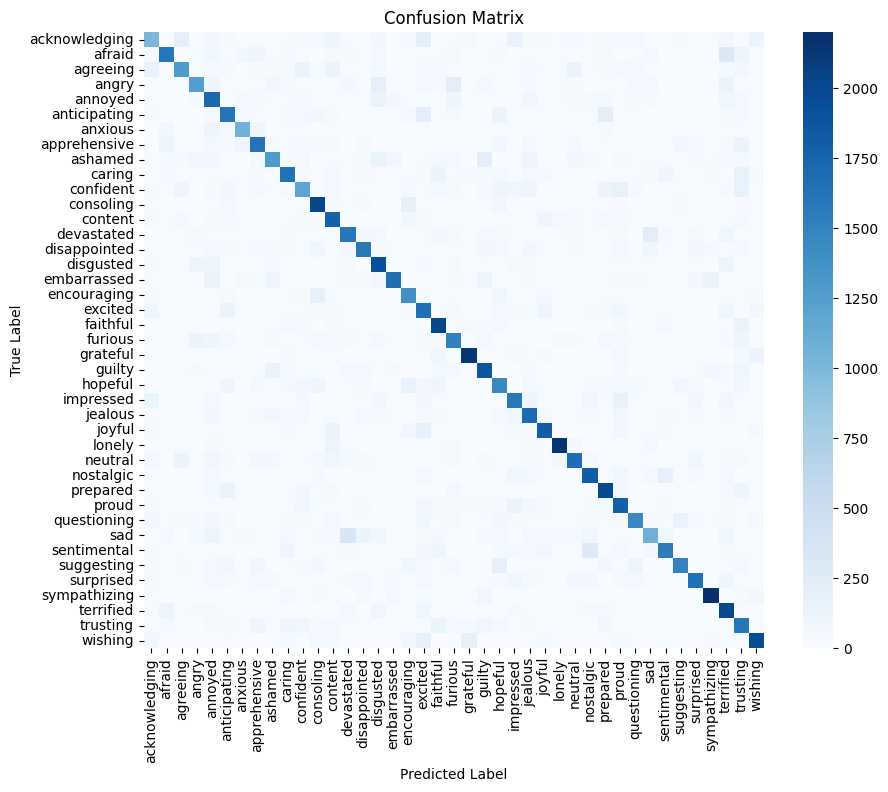

In [ ]:
# Generate predictions for the test set
predictions = loaded_model.predict([test_input_ids, test_attention_mask])
predicted_labels = np.argmax(predictions, axis=1)

# Compute confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Create a DataFrame from the confusion matrix
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=False, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Calculate precision and recall for each class
report = classification_report(test_labels, predicted_labels, digits=4, target_names=label_encoder.classes_)

print(report)

               precision    recall  f1-score   support

acknowledging     0.4715    0.3717    0.4157      2720
       afraid     0.6783    0.5591    0.6130      2858
     agreeing     0.5528    0.4636    0.5043      2776
        angry     0.6316    0.4567    0.5301      2737
      annoyed     0.4731    0.5850    0.5231      2937
 anticipating     0.5694    0.5628    0.5661      2880
      anxious     0.6592    0.6169    0.6374      1728
 apprehensive     0.5960    0.5913    0.5936      2745
      ashamed     0.5709    0.4704    0.5158      2749
       caring     0.5921    0.5836    0.5878      2810
    confident     0.4867    0.4290    0.4560      2774
    consoling     0.6216    0.7239    0.6689      2811
      content     0.5575    0.6544    0.6021      2711
   devastated     0.5815    0.5725    0.5770      2779
 disappointed     0.6259    0.5672    0.5951      2791
    disgusted     0.5817    0.6941    0.6329      2775
  embarrassed     0.7415    0.5905    0.6574      2808
  encoura

### With Info about Previous Utterance

#### Prepare Data

In [ ]:
# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')
# Enable XLA
tf.config.optimizer.set_jit(True)

In [ ]:
# Split data into train, validation, and test sets
train_df, test_df = train_test_split(undersampled_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)
print('number of train samples : {}'.format(len(train_df)))
print('number of test samples : {}'.format(len(test_df)))
print('number of val samples : {}'.format(len(val_df)))

number of train samples : 361540
number of test samples : 112982
number of val samples : 90385


In [ ]:
# Encode labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df['label'])
val_labels = label_encoder.transform(val_df['label'])
test_labels = label_encoder.transform(test_df['label'])

In [ ]:
# Load ALBERT tokenizer (fast version)
tokenizer = AlbertTokenizerFast.from_pretrained('albert-base-v2')

In [ ]:
# Tokenize current utterance
max_length = 35  # Maximum sequence length (=95 percentile of utterance langth)
train_tokens_current = tokenizer.batch_encode_plus(
    train_df['uttr'].tolist(),
    max_length=max_length,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)
val_tokens_current = tokenizer.batch_encode_plus(
    val_df['uttr'].tolist(),
    max_length=max_length,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

In [ ]:
# Tokenize previous utterance
max_length = 35  # Maximum sequence length (>95 percentile of utterance langth)
train_tokens_prev = tokenizer.batch_encode_plus(
    train_df['previous_uttr'].tolist(),
    max_length=max_length,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)
val_tokens_prev= tokenizer.batch_encode_plus(
    val_df['previous_uttr'].tolist(),
    max_length=max_length,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

In [ ]:
# Convert tokenized input to numpy arrays
train_current_input_ids = np.array(train_tokens_current['input_ids'])
train_current_attention_mask = np.array(train_tokens_current['attention_mask'])

val_current_input_ids = np.array(val_tokens_current['input_ids'])
val_current_attention_mask= np.array(val_tokens_current['attention_mask'])

# Convert tokenized input to numpy arrays
train_prev_input_ids = np.array(train_tokens_prev['input_ids'])
train_prev_attention_mask = np.array(train_tokens_prev['attention_mask'])

val_prev_input_ids = np.array(val_tokens_prev['input_ids'])
val_prev_attention_mask = np.array(val_tokens_prev['attention_mask'])

In [ ]:
len(train_current_input_ids)

361540

In [ ]:
len(val_current_input_ids)

90385

#### Train Model

In [ ]:
albert_model = TFAlbertModel.from_pretrained('albert-base-v2')
albert_model.trainable = False

Some layers from the model checkpoint at albert-base-v2 were not used when initializing TFAlbertModel: ['predictions']
- This IS expected if you are initializing TFAlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFAlbertModel were initialized from the model checkpoint at albert-base-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


In [ ]:
input_ids = tfkl.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
attention_mask = tfkl.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')
prev_input_ids = tfkl.Input(shape=(max_length,), dtype=tf.int32, name='prev_input_ids')
prev_attention_mask = tfkl.Input(shape=(max_length,), dtype=tf.int32, name='prev_attention_mask')

albert_output = albert_model(input_ids={'input_ids': input_ids, 'attention_mask': attention_mask}).last_hidden_state
prev_albert_output = albert_model(input_ids={'input_ids': prev_input_ids, 'attention_mask': prev_attention_mask}).last_hidden_state

# Apply Bidirectional LSTM to the current utterance
lstm_units = 64
lstm_output = tfkl.Bidirectional(tfkl.LSTM(lstm_units, return_sequences=True))(albert_output)

# Apply Bidirectional LSTM to the previous utterance
prev_lstm_output = tfkl.Bidirectional(tfkl.LSTM(lstm_units, return_sequences=True))(prev_albert_output)

# Concatenate the outputs
combined_output = tfkl.Concatenate()([lstm_output, prev_lstm_output])

# Apply Bidirectional LSTM after concatenation
combined_lstm_output = tfkl.Bidirectional(tfkl.LSTM(lstm_units))(combined_output)

hidden = tfkl.Dense(1000, activation='relu')(combined_lstm_output)
output = tfkl.Dense(len(label_encoder.classes_), activation='softmax')(hidden)

model = Model(inputs=[input_ids, attention_mask, prev_input_ids, prev_attention_mask], outputs=output)

# Compile the model
learning_rate = 0.5e-3
optimizer = AdamW(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


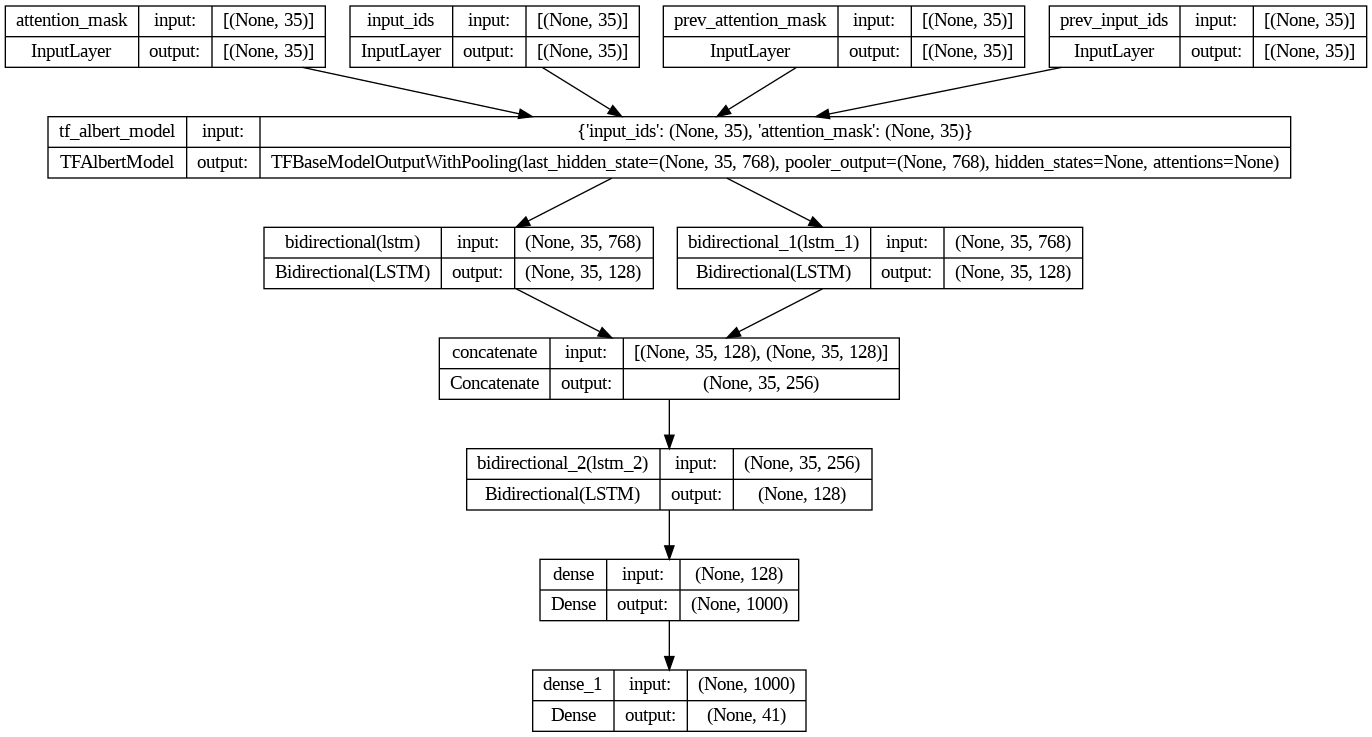

In [ ]:
# Plot the model
plot_model(model, to_file='albert_with_prev.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

# Train the model
model.fit(
    [train_current_input_ids, train_current_attention_mask, train_prev_input_ids, train_prev_attention_mask],
    train_labels,
    validation_data=([val_current_input_ids, val_current_attention_mask, val_prev_input_ids, val_prev_attention_mask], val_labels),
    batch_size=32,
    epochs=5,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/5
11299/11299 [==============================] - 812s 63ms/step - loss: 1.7506 - accuracy: 0.4894 - val_loss: 1.4526 - val_accuracy: 0.5643
Epoch 2/5
11299/11299 [==============================] - 723s 64ms/step - loss: 1.3354 - accuracy: 0.5950 - val_loss: 1.3459 - val_accuracy: 0.5895
Epoch 3/5
11299/11299 [==============================] - 704s 62ms/step - loss: 1.1993 - accuracy: 0.6303 - val_loss: 1.2863 - val_accuracy: 0.6078
Epoch 4/5
11299/11299 [==============================] - 700s 62ms/step - loss: 1.1060 - accuracy: 0.6551 - val_loss: 1.2789 - val_accuracy: 0.6100
Epoch 5/5
11299/11299 [==============================] - 702s 62ms/step - loss: 1.0282 - accuracy: 0.6767 - val_loss: 1.2584 - val_accuracy: 0.6207


In [ ]:
model.save('albert_with_prev.h5')

#### Evaluate Model

In [ ]:
# Register the custom object within the context manager
with tf.keras.utils.custom_object_scope({'TFAlbertModel': TFAlbertModel}):
    loaded_model = tf.keras.models.load_model('albert_with_prev.h5')

In [ ]:
max_length = 35  # Maximum sequence length (>95 percentile of utterance langth)
test_tokens_prev = tokenizer.batch_encode_plus(
    test_df['previous_uttr'].tolist(),
    max_length=max_length,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

test_tokens_current = tokenizer.batch_encode_plus(
    test_df['uttr'].tolist(),
    max_length=max_length,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

test_current_input_ids = np.array(test_tokens_current['input_ids'])
test_current_attention_mask = np.array(test_tokens_current['attention_mask'])


test_prev_input_ids = np.array(test_tokens_prev['input_ids'])
test_prev_attention_mask = np.array(test_tokens_prev['attention_mask'])

3531/3531 [==============================] - 485s 130ms/step


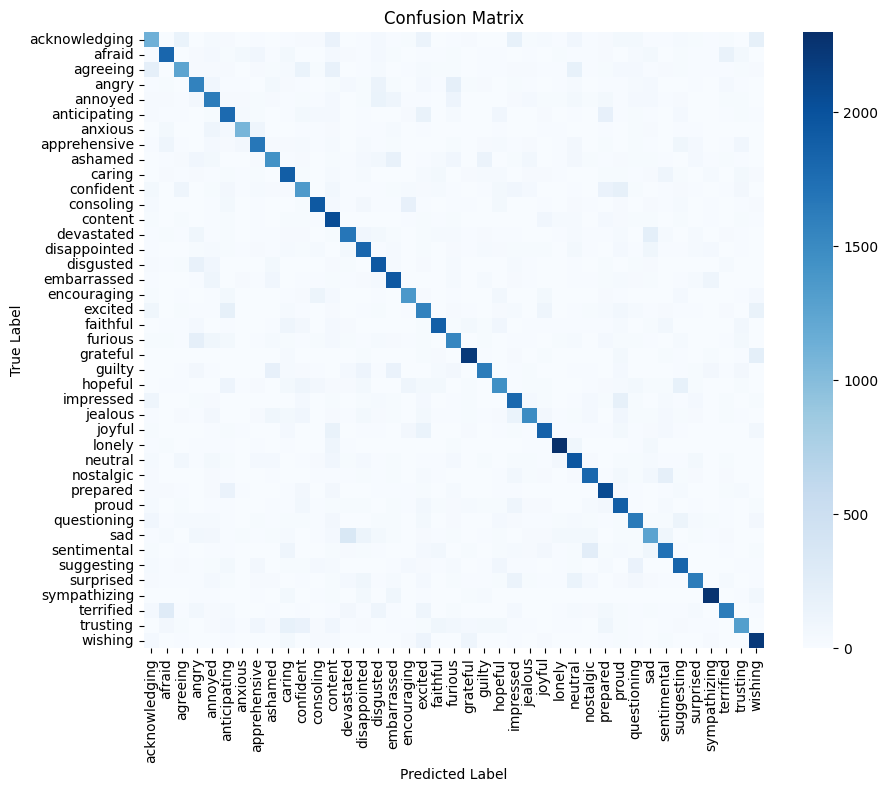

In [ ]:
# Generate predictions for the test set
predictions = loaded_model.predict([test_current_input_ids, test_current_attention_mask, test_prev_input_ids, test_prev_attention_mask])
predicted_labels = np.argmax(predictions, axis=1)

# Compute confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Create a DataFrame from the confusion matrix
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=False, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Calculate precision and recall for each class
report = classification_report(test_labels, predicted_labels, digits=4, target_names=label_encoder.classes_)
print(report)

               precision    recall  f1-score   support

acknowledging     0.4741    0.4147    0.4424      2720
       afraid     0.6699    0.6354    0.6522      2858
     agreeing     0.6017    0.4517    0.5160      2776
        angry     0.5564    0.5765    0.5663      2737
      annoyed     0.5344    0.5550    0.5445      2937
 anticipating     0.5633    0.6177    0.5893      2880
      anxious     0.7193    0.6244    0.6685      1728
 apprehensive     0.6562    0.6084    0.6314      2745
      ashamed     0.6014    0.5209    0.5583      2749
       caring     0.5804    0.6733    0.6234      2810
    confident     0.5049    0.4859    0.4952      2774
    consoling     0.7351    0.6891    0.7113      2811
      content     0.5171    0.7569    0.6145      2711
   devastated     0.6221    0.6042    0.6130      2779
 disappointed     0.5981    0.6532    0.6244      2791
    disgusted     0.6327    0.7020    0.6655      2775
  embarrassed     0.6359    0.6934    0.6634      2808
  encoura

### With Info about Subsequent Utterance

#### Prepare Data

In [ ]:
# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')
# Enable XLA
tf.config.optimizer.set_jit(True)

In [ ]:
# Split data into train, validation, and test sets
train_df, test_df = train_test_split(undersampled_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)
print('number of train samples : {}'.format(len(train_df)))
print('number of test samples : {}'.format(len(test_df)))
print('number of val samples : {}'.format(len(val_df)))

number of train samples : 361540
number of test samples : 112982
number of val samples : 90385


In [ ]:
# Encode labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df['label'])
val_labels = label_encoder.transform(val_df['label'])
test_labels = label_encoder.transform(test_df['label'])

In [ ]:
# Load ALBERT tokenizer (fast version)
tokenizer = AlbertTokenizerFast.from_pretrained('albert-base-v2')

In [ ]:
# Tokenize current utterance
max_length = 35  # Maximum sequence length (=95 percentile of utterance langth)
train_tokens_current = tokenizer.batch_encode_plus(
    train_df['uttr'].tolist(),
    max_length=max_length,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)
val_tokens_current = tokenizer.batch_encode_plus(
    val_df['uttr'].tolist(),
    max_length=max_length,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

In [ ]:
# Tokenize subsequent utterance
max_length = 35  # Maximum sequence length (>95 percentile of utterance langth)
train_tokens_next = tokenizer.batch_encode_plus(
    train_df['subsequent_uttr'].tolist(),
    max_length=max_length,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)
val_tokens_next= tokenizer.batch_encode_plus(
    val_df['subsequent_uttr'].tolist(),
    max_length=max_length,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

In [ ]:
# Convert tokenized input to numpy arrays
train_current_input_ids = np.array(train_tokens_current['input_ids'])
train_current_attention_mask = np.array(train_tokens_current['attention_mask'])

val_current_input_ids = np.array(val_tokens_current['input_ids'])
val_current_attention_mask= np.array(val_tokens_current['attention_mask'])

# Convert tokenized input to numpy arrays
train_next_input_ids = np.array(train_tokens_next['input_ids'])
train_next_attention_mask = np.array(train_tokens_next['attention_mask'])

val_next_input_ids = np.array(val_tokens_next['input_ids'])
val_next_attention_mask = np.array(val_tokens_next['attention_mask'])

#### Train Model

In [ ]:
albert_model = TFAlbertModel.from_pretrained('albert-base-v2')
albert_model.trainable = False

Some layers from the model checkpoint at albert-base-v2 were not used when initializing TFAlbertModel: ['predictions']
- This IS expected if you are initializing TFAlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFAlbertModel were initialized from the model checkpoint at albert-base-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


In [ ]:
input_ids = tfkl.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
attention_mask = tfkl.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')
next_input_ids = tfkl.Input(shape=(max_length,), dtype=tf.int32, name='next_input_ids')
next_attention_mask = tfkl.Input(shape=(max_length,), dtype=tf.int32, name='next_attention_mask')

albert_output = albert_model(input_ids={'input_ids': input_ids, 'attention_mask': attention_mask}).last_hidden_state
next_albert_output = albert_model(input_ids={'input_ids': next_input_ids, 'attention_mask': next_attention_mask}).last_hidden_state

# Apply Bidirectional LSTM to the current utterance
lstm_units = 64
lstm_output = tfkl.Bidirectional(tfkl.LSTM(lstm_units, return_sequences=True))(albert_output)

# Apply Bidirectional LSTM to the next utterance
next_lstm_output = tfkl.Bidirectional(tfkl.LSTM(lstm_units, return_sequences=True))(next_albert_output)

# Concatenate the outputs
combined_output = tfkl.Concatenate()([lstm_output, next_lstm_output])

# Apply Bidirectional LSTM after concatenation
combined_lstm_output = tfkl.Bidirectional(tfkl.LSTM(lstm_units))(combined_output)

hidden = tfkl.Dense(1000, activation='relu')(combined_lstm_output)
output = tfkl.Dense(len(label_encoder.classes_), activation='softmax')(hidden)

model = Model(inputs=[input_ids, attention_mask, next_input_ids, next_attention_mask], outputs=output)

# Compile the model
learning_rate = 0.5e-3
optimizer = AdamW(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


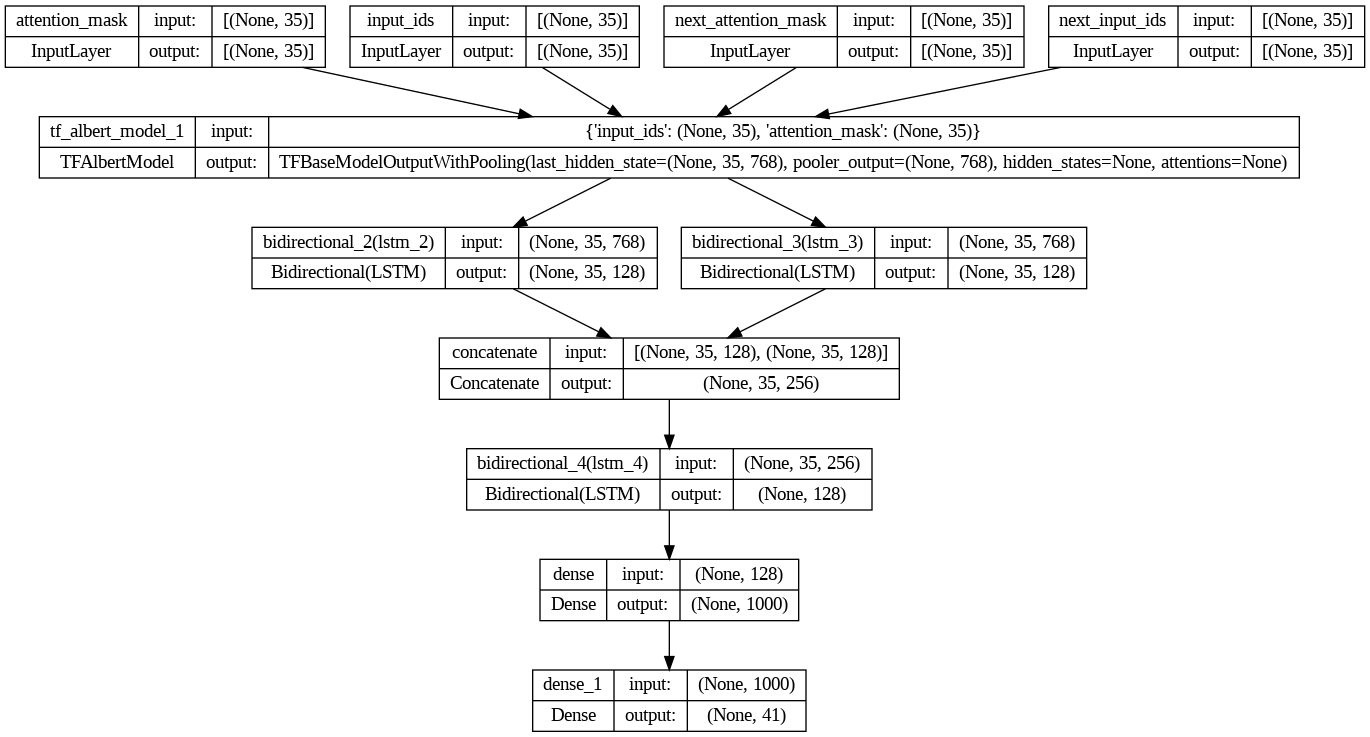

In [ ]:
# Plot the model
plot_model(model, to_file='albert_with_next.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

# Train the model
model.fit(
    [train_current_input_ids, train_current_attention_mask, train_next_input_ids, train_next_attention_mask],
    train_labels,
    validation_data=([val_current_input_ids, val_current_attention_mask, val_next_input_ids, val_next_attention_mask], val_labels),
    batch_size=32,
    epochs=5,
    callbacks=[early_stopping],
    verbose=1
    )

Epoch 1/5
11299/11299 [==============================] - 769s 63ms/step - loss: 1.7524 - accuracy: 0.4887 - val_loss: 1.4894 - val_accuracy: 0.5564
Epoch 2/5
11299/11299 [==============================] - 755s 67ms/step - loss: 1.3544 - accuracy: 0.5887 - val_loss: 1.3515 - val_accuracy: 0.5916
Epoch 3/5
11299/11299 [==============================] - 730s 65ms/step - loss: 1.2207 - accuracy: 0.6249 - val_loss: 1.3118 - val_accuracy: 0.6004
Epoch 4/5
11299/11299 [==============================] - 738s 65ms/step - loss: 1.1297 - accuracy: 0.6485 - val_loss: 1.2751 - val_accuracy: 0.6125
Epoch 5/5
11299/11299 [==============================] - 692s 61ms/step - loss: 1.0551 - accuracy: 0.6694 - val_loss: 1.2923 - val_accuracy: 0.6105


In [ ]:
model.save('albert_with_next.h5')

#### Evaluate Model

In [ ]:
# Register the custom object within the context manager
with tf.keras.utils.custom_object_scope({'TFAlbertModel': TFAlbertModel}):
    loaded_model = tf.keras.models.load_model('albert_with_next.h5')

In [ ]:
max_length = 35
test_tokens_next = tokenizer.batch_encode_plus(
    test_df['subsequent_uttr'].tolist(),
    max_length=max_length,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

test_tokens_current = tokenizer.batch_encode_plus(
    test_df['uttr'].tolist(),
    max_length=max_length,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

test_current_input_ids = np.array(test_tokens_current['input_ids'])
test_current_attention_mask = np.array(test_tokens_current['attention_mask'])


test_next_input_ids = np.array(test_tokens_next['input_ids'])
test_next_attention_mask = np.array(test_tokens_next['attention_mask'])

3531/3531 [==============================] - 166s 38ms/step


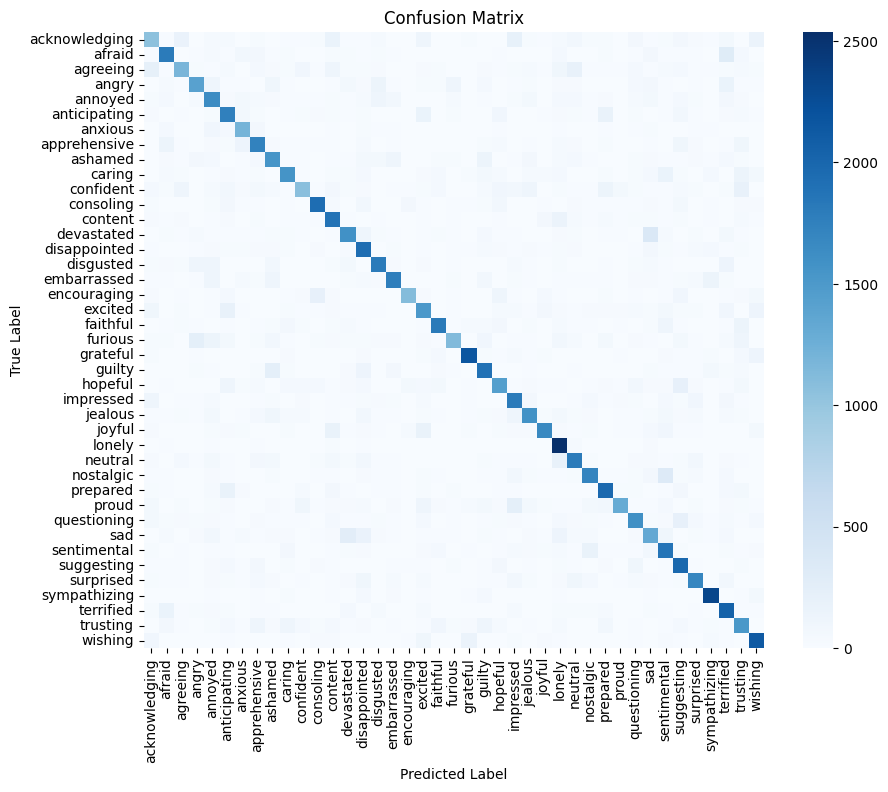

In [ ]:
# Generate predictions for the test set
predictions = loaded_model.predict([test_current_input_ids, test_current_attention_mask, test_next_input_ids, test_next_attention_mask])
predicted_labels = np.argmax(predictions, axis=1)

# Compute confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Create a DataFrame from the confusion matrix
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=False, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Calculate precision and recall for each class
report = classification_report(test_labels, predicted_labels, digits=4, target_names=label_encoder.classes_)

print(report)

               precision    recall  f1-score   support

acknowledging     0.4526    0.3882    0.4180      2720
       afraid     0.6387    0.6333    0.6360      2858
     agreeing     0.6013    0.4254    0.4983      2776
        angry     0.6168    0.5170    0.5625      2737
      annoyed     0.5054    0.5584    0.5306      2937
 anticipating     0.5458    0.6122    0.5771      2880
      anxious     0.6073    0.6991    0.6500      1728
 apprehensive     0.5964    0.6321    0.6137      2745
      ashamed     0.5383    0.5653    0.5515      2749
       caring     0.6408    0.5548    0.5947      2810
    confident     0.5927    0.3872    0.4684      2774
    consoling     0.7302    0.6905    0.7098      2811
      content     0.5656    0.6931    0.6229      2711
   devastated     0.6011    0.5732    0.5868      2779
 disappointed     0.5338    0.6951    0.6039      2791
    disgusted     0.6742    0.6519    0.6629      2775
  embarrassed     0.6973    0.6332    0.6637      2808
  encoura

# **Extension: ChatBot**
fine-tuning a vanilla GPT-2.  
Important: Don't run preprocess for this

In [6]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM,TrainingArguments,DataCollatorForLanguageModeling, Trainer 
from datetime import datetime
from datasets import Dataset,DatasetDict
from nltk.metrics import f_measure
import random

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data prepration

In [47]:
# Calculate the number of dialogues to keep based on a percentage
percentage_to_keep = 0.05
num_dialogues_to_keep = int(len(df['dialogue_id'].unique()) * percentage_to_keep)

# Randomly select the dialogues to keep
selected_dialogue_ids = df['dialogue_id'].sample(n=num_dialogues_to_keep, random_state=42)

# Filter the DataFrame to keep only the selected dialogues
df_filtered = df[df['dialogue_id'].isin(selected_dialogue_ids)]

In [48]:
dialogue_groups = df_filtered.groupby('dialogue_id')['uttr'].apply(list)
train_dialogue_ids, val_dialogue_ids = train_test_split(dialogue_groups.index, test_size=0.2, random_state=42)
train_df = df_filtered[df_filtered['dialogue_id'].isin(train_dialogue_ids)]
validation_df = df_filtered[df_filtered['dialogue_id'].isin(val_dialogue_ids)]

In [49]:
print(len(train_df),len(validation_df))

130438 32492


In [50]:
def parse(df):
  grouped = df_filtered.groupby('dialogue_id')

  # Initialize list to store dialogue dictionaries
  dialogues = []
  # Iterate over dialogue groups
  for _, group in grouped:
      # Initialize list to store utterance dictionaries
      utterances = []
      
      # Iterate over rows in the group
      for _, row in group.iterrows():
          # Extract speaker and text values
          speaker = row['turn']
          text = row['uttr']
          
          # Create utterance dictionary
          utterance = {'speaker': speaker, 'text': text}
          
          # Append utterance to list
          utterances.append(utterance)
      
      # Create dialogue dictionary and append to list
      dialogue = {'utterances': utterances}
      dialogues.append(dialogue)
  return dialogues

In [52]:
training_data = parse(train_df)
validation_data = parse(validation_df)

In [53]:
model_id = "gpt2"  # Replace with your desired model ID
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
# Move the model to the device
model = model.to(device)

In [54]:
def sample_to_string(sample, eos_token):
    # Join dialogue strings
    dialogue = eos_token.join(f"{utterance['speaker']}: {utterance['text']}" for utterance in sample['utterances'])
    return dialogue

In [55]:
training_data_str = [sample_to_string(dialogue, tokenizer.eos_token) for dialogue in training_data]
validation_data_str = [sample_to_string(dialogue, tokenizer.eos_token) for dialogue in validation_data]

In [56]:
train_data = Dataset.from_dict({'text': training_data_str})
valid_data = Dataset.from_dict({'text': validation_data_str})

In [57]:
data = DatasetDict()
data['train'] = train_data
data['validation'] = valid_data
data['test'] = valid_data

In [58]:
def tokenize_function(examples):
    input_encodings = tokenizer(examples["text"], padding=True, truncation=True)
    sample = {
        'input_ids': input_encodings.input_ids
    }
    return sample
tokenized_data = data.map(tokenize_function, batched=True)

Map:   0%|          | 0/48996 [00:00<?, ? examples/s]

Map:   0%|          | 0/48996 [00:00<?, ? examples/s]

Map:   0%|          | 0/48996 [00:00<?, ? examples/s]

In [59]:
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

## Training

In [60]:
training_args = TrainingArguments(
    "chatingWithEdos", 
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    learning_rate=6.25e-5,
    lr_scheduler_type="linear",
    num_train_epochs = 3
)

In [61]:
trainer = Trainer(
    model=model, 
    args=training_args, 
    train_dataset=tokenized_data['train'], 
    eval_dataset=tokenized_data['validation'],
    data_collator=data_collator
)

In [62]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
500,3.196400,3.013217
1000,3.115000,2.954227
1500,3.094700,2.914087
2000,2.982200,2.880760
2500,2.975000,2.854975
3000,2.977700,2.836400
3500,2.921200,2.820138
4000,2.907500,2.811539
4500,2.909700,2.806620


TrainOutput(global_step=4593, training_loss=3.0067662845996117, metrics={'train_runtime': 14264.5702, 'train_samples_per_second': 10.304, 'train_steps_per_second': 0.322, 'total_flos': 1.4499760333824e+16, 'train_loss': 3.0067662845996117, 'epoch': 3.0})

In [63]:
checkpoint_path = f"chatbot_{datetime.now().strftime('%Y_%m_%d_%H_%M_%S')}"
tokenizer.save_pretrained(checkpoint_path)
model.save_pretrained(checkpoint_path)

## Testing

In [103]:
random.seed(1)

idx = random.choice(range(len(validation_data)))
dialogue = validation_data[idx]

In [104]:
response_idx = len(dialogue['utterances']) // 2

original_response = dialogue['utterances'][response_idx]
original_response_string = f"{original_response['speaker']}: {original_response['text']}"
original_response_string

'2: How about a bath ?'

In [105]:
context = {
    'utterances': dialogue['utterances'][:response_idx]
}
context_string = sample_to_string(context, tokenizer.eos_token)
context_string

"1: It 's strange . Physically , I feel like I could demolish a tank . Mentally , I just feel drained ."

In [67]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)
model = AutoModelForCausalLM.from_pretrained(checkpoint_path , torch_dtype=torch.float16)
# Move the model to the same device as the input encoding
model = model.to(device)

In [106]:
# Encode context
input_encoding = tokenizer(context_string, return_tensors='pt').to(device)
# Generate response
output_ids = model.generate(input_encoding.input_ids.to(device), max_new_tokens=32, do_sample=True, top_p=0.9, top_k=0, pad_token_id=tokenizer.eos_token_id)
# Decode generated response
generated_response = tokenizer.decode(output_ids[0, input_encoding.input_ids.size(1):], skip_special_tokens=True)

In [107]:
generated_response

" But physically, I'm very happy. I don 't want to talk to anyone. Everything's fine. I'm a human. I '"

In [108]:
# Function to calculate F1 score
def calculate_f1_score(generated_response, original_response_string):
    # Tokenize the generated and original responses
    generated_tokens = generated_response.lower().split()
    original_tokens = original_response_string.lower().split()
    f1_score = f_measure(set(generated_tokens), set(original_tokens))
    
    return  f1_score


f1_score = calculate_f1_score(generated_response, original_response_string)

print(f"F1 Score: {f1_score}")


F1 Score: 0.08695652173913043


## Chatting

In [71]:
# Load fine-tuned model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)
model = AutoModelForCausalLM.from_pretrained(checkpoint_path , torch_dtype=torch.float16)
# Move the model to the same device
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [102]:
# Get user input
user_input = input("User: ")
# Encode context
input_encoding = tokenizer(user_input, return_tensors='pt').to(device)
# Generate response
output_ids = model.generate(input_encoding.input_ids.to(device), max_new_tokens=20, do_sample=True, top_p=0.9, top_k=0, pad_token_id=tokenizer.eos_token_id)
# Decode generated response
generated_response = tokenizer.decode(output_ids[0, input_encoding.input_ids.size(1):], skip_special_tokens=True)
print(generated_response)

User: What is your name?
 Aurelie Pangy. Do you belong to either your native or foreign country? Is anyone there
